<h1>Build feature and output arrays

In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder

# lists for all data
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

with open(f"data/WPPs+production+reanalysis/WPPs+production+wind_new.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# collect data
for wpp in WPP_production_wind:
    all_turbine_types.append(str(wpp["Turbine"]))
    all_hub_heights.append(wpp["Hub_height"])
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
    all_production_data.append(wpp["Production"])

# One-Hot-Encoding for turbine types
encoder = OneHotEncoder(sparse_output=False)
turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

# convert to datetime
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# calculate age
ref_date = pd.Timestamp("2024-12-01")
ages = ref_date.year * 12 + ref_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# create combined features and output lists
combined_features_raw = []
output_raw = []

# convert data in feature arrays
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # repetitions for common features
    turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])
    capacities_repeated = np.full((num_rows, 1), all_capacities[idx])

    # extract production values and wind speeds
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    # combine all features
    combined_chunk = np.hstack((
        turbine_type_repeated,
        hub_height_repeated,
        age_repeated,
        wind_speeds
    ))

    # add the data
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

# combine all data chunks to one array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)

# round all values to two decimal places
combined_features_raw = np.round(combined_features_raw, decimals=4)
output_raw = np.round(output_raw, decimals=4)

<h1>Plot capacity ranges

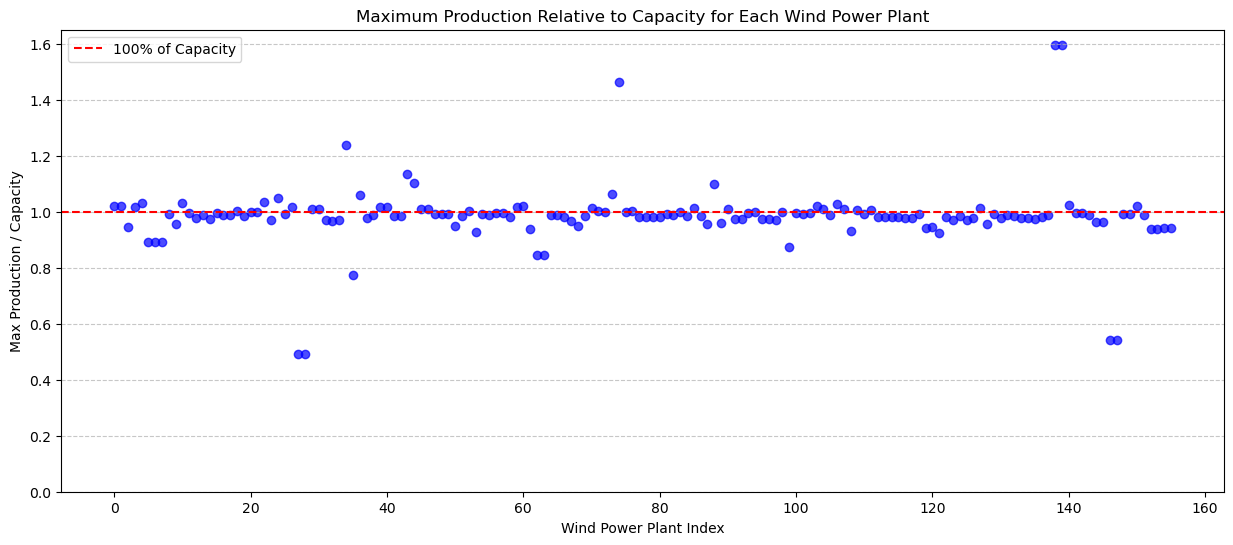

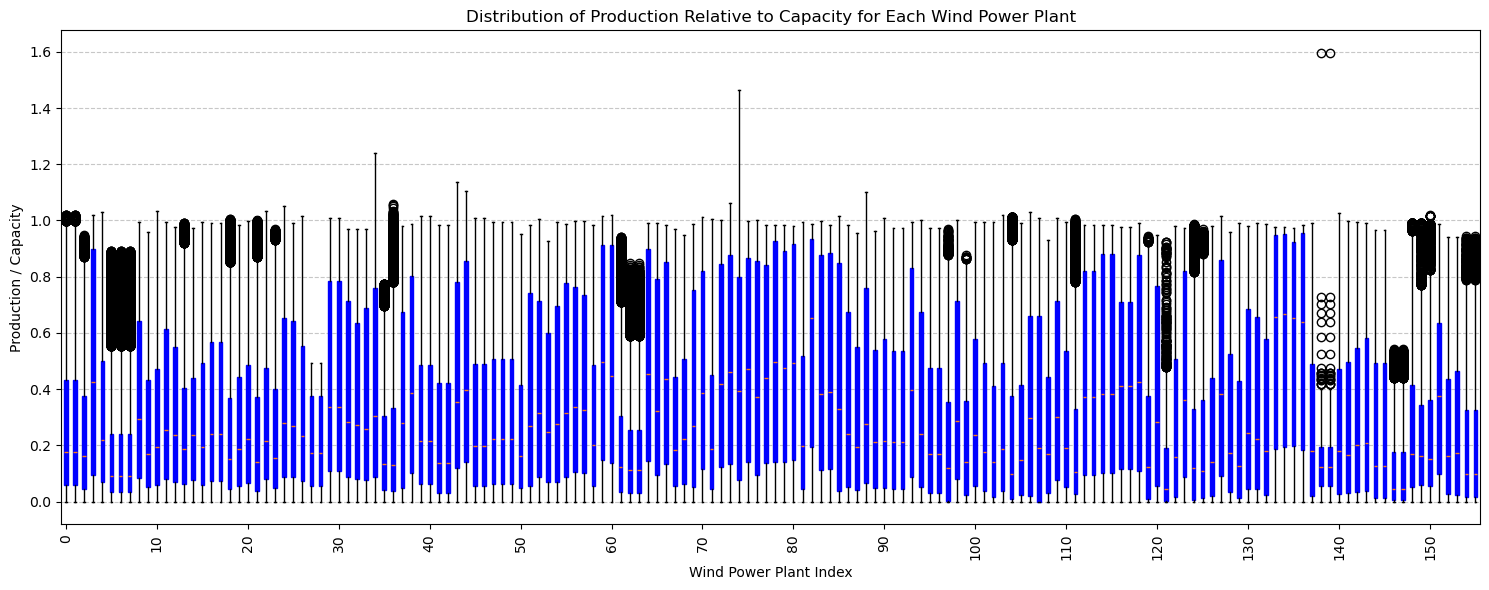

In [4]:
import matplotlib.pyplot as plt

# Prepare data for the boxplot (one boxplot per WPP)
production_ratios_per_wpp = [[entry[1] / capacity for entry in production_data] for production_data, capacity in zip(all_production_data, all_capacities)]
max_production_ratio_per_wpp = [max(ratios) for ratios in production_ratios_per_wpp]

# Plotting
plt.figure(figsize=(15, 6))
plt.scatter(range(len(max_production_ratio_per_wpp)), max_production_ratio_per_wpp, alpha=0.7, c='blue')
plt.axhline(y=1.0, color='red', linestyle='--', label='100% of Capacity')
plt.xlabel('Wind Power Plant Index')
plt.ylabel('Max Production / Capacity')
plt.title('Maximum Production Relative to Capacity for Each Wind Power Plant')
plt.ylim(0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot boxplot with thin boxes
plt.figure(figsize=(15, 6))
plt.boxplot(production_ratios_per_wpp, widths=0.4, vert=True, patch_artist=True, showfliers=True, boxprops=dict(facecolor='blue', color='blue'))
plt.xlabel('Wind Power Plant Index')
plt.ylabel('Production / Capacity')
plt.title('Distribution of Production Relative to Capacity for Each Wind Power Plant')
step = 10  # Interval for the ticks
num_wpps = len(all_production_data)
tick_positions = np.arange(0, num_wpps, step) + 1  # 1-indexed positions for boxplot
tick_labels = np.arange(0, num_wpps, step)  # Actual WPP indices (0, 10, 20, ...)
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<h1>Countries

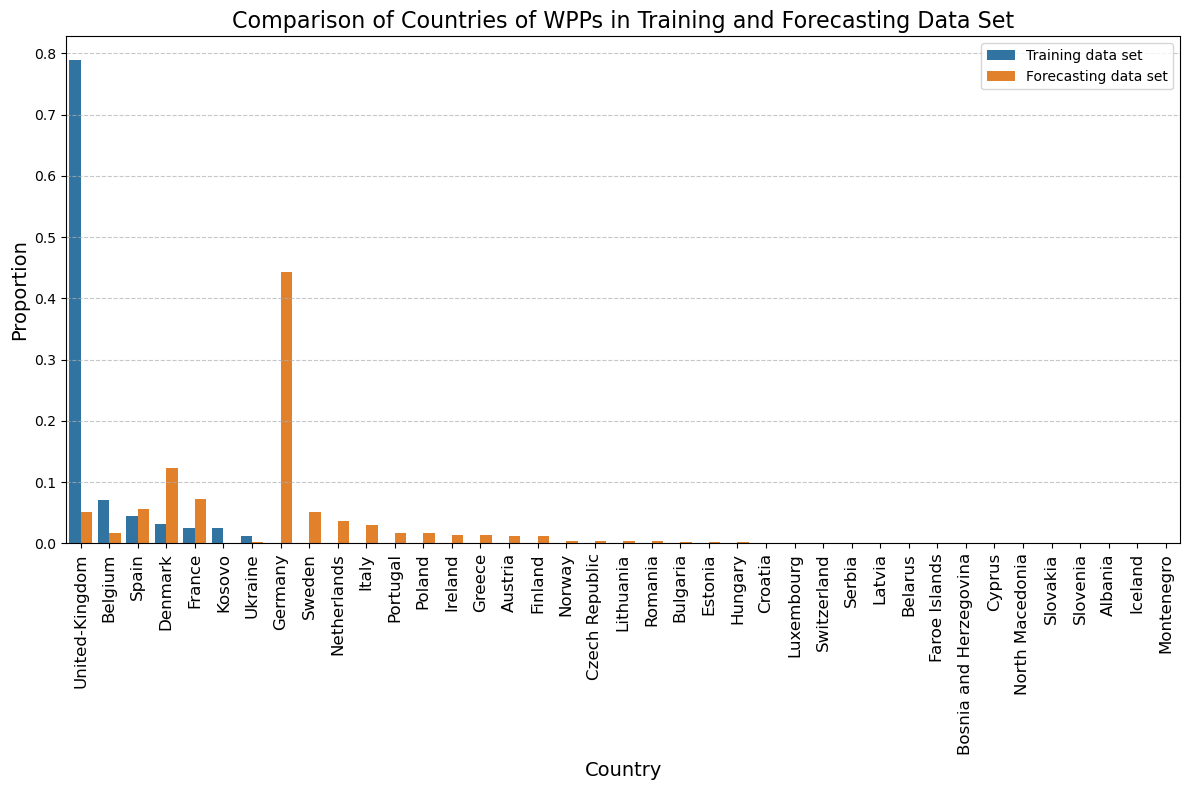

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
json_path = "data/WPPs+production/WPPs+production_new.json"
file_path_excel = "data/WPPs/Windfarms_Europe_20241123.xlsx"

# Load JSON data
with open(json_path, "r", encoding="utf-8") as file:
    wpps_data = pd.read_json(file)

# Count occurrences of each country in the JSON data
country_counts_json = wpps_data["Country"].value_counts(normalize=True).reset_index()
country_counts_json.columns = ["Country", "Proportion"]
country_counts_json["Source"] = "Training data set"

# Load Excel data
data_excel = pd.read_excel(file_path_excel, sheet_name='Windfarms')
data_excel = data_excel.drop(0)  # Remove first row (after headlines)
country_counts_excel = data_excel["Country"].value_counts(normalize=True).reset_index()
country_counts_excel.columns = ["Country", "Proportion"]
country_counts_excel["Source"] = "Forecasting data set"

# Combine both datasets into one DataFrame
combined_data = pd.concat([country_counts_json, country_counts_excel]).reset_index(drop=True)

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=combined_data, x="Country", y="Proportion", hue="Source", dodge=True)

plt.xlabel("Country", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.title("Comparison of Countries of WPPs in Training and Forecasting Data Set", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.legend(title=None)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<h1>Onshore / Offshore

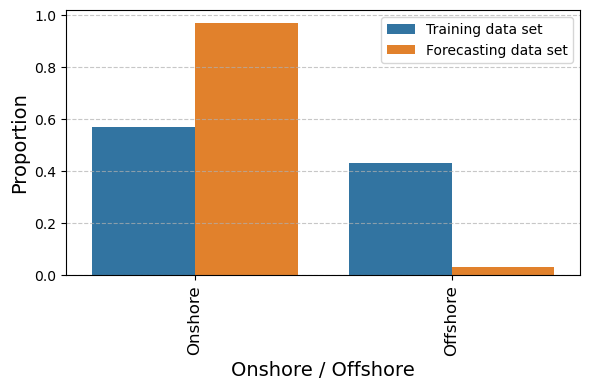

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
json_path = "data/WPPs+production/WPPs+production_new.json"
file_path_excel = "data/WPPs/Windfarms_Europe_20241123.xlsx"

# Load JSON data
with open(json_path, "r", encoding="utf-8") as file:
    wpps_data = pd.read_json(file)

# Load Excel data
data_excel = pd.read_excel(file_path_excel, sheet_name='Windfarms')
data_excel = data_excel.drop(0)  # Remove first row (after headlines)

# Standardise Onshore/Offshore labels
data_excel["Offshore Shore distance"] = data_excel["Offshore Shore distance"].apply(lambda x: "Onshore" if x == "No" else "Offshore")
wpps_data["Type"] = wpps_data["Type"].replace({"Wind Onshore ": "Onshore", "Wind Offshore ": "Offshore"})

# Count occurrences of each country in the JSON data
shore_counts_json = wpps_data["Type"].value_counts(normalize=True).reset_index()
shore_counts_json.columns = ["Onshore / Offshore", "Proportion"]
shore_counts_json["Source"] = "Training data set"

shore_counts_excel = data_excel["Offshore Shore distance"].value_counts(normalize=True).reset_index()
shore_counts_excel.columns = ["Onshore / Offshore", "Proportion"]
shore_counts_excel["Source"] = "Forecasting data set"

# Combine both datasets into one DataFrame
combined_data = pd.concat([shore_counts_json, shore_counts_excel]).reset_index(drop=True)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.barplot(data=combined_data, x="Onshore / Offshore", y="Proportion", hue="Source", dodge=True)

plt.xlabel("Onshore / Offshore", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.legend(title=None)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h1>Probability distributions training and forecasting data set

Training data set: number of turbine types 53
Forecasting data set: number of turbine types 547


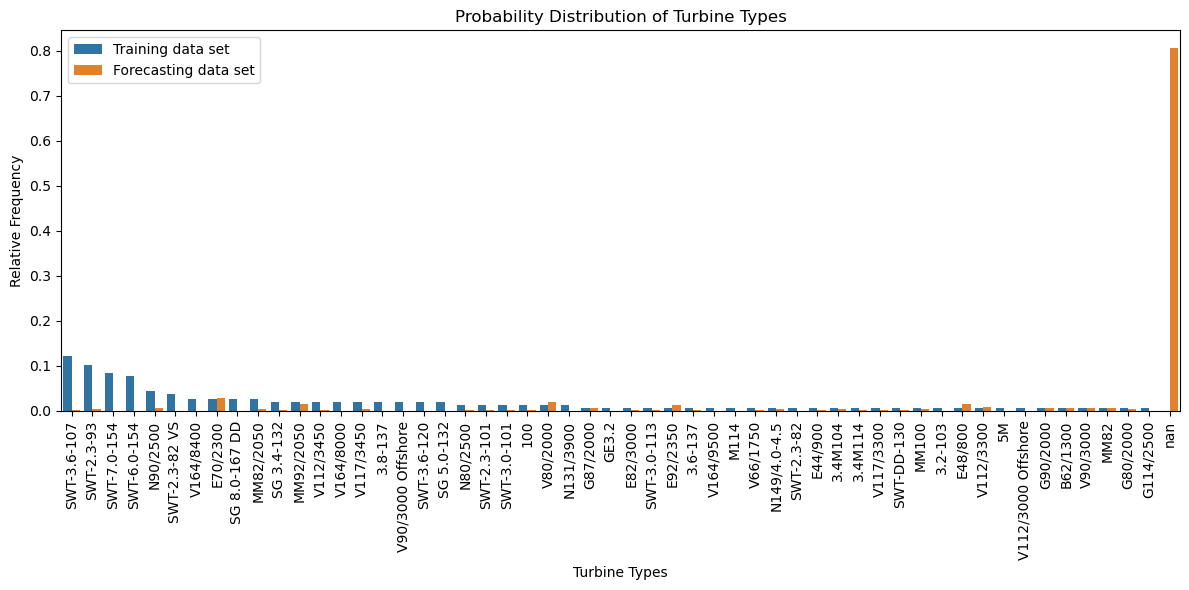

Training data set: minimal Hub Heights (m): 47.0, maximal Hub Heights (m): 145.0
Forecasting data set: minimal Hub Heights (m): 14.0, maximal Hub Heights (m): 205.0


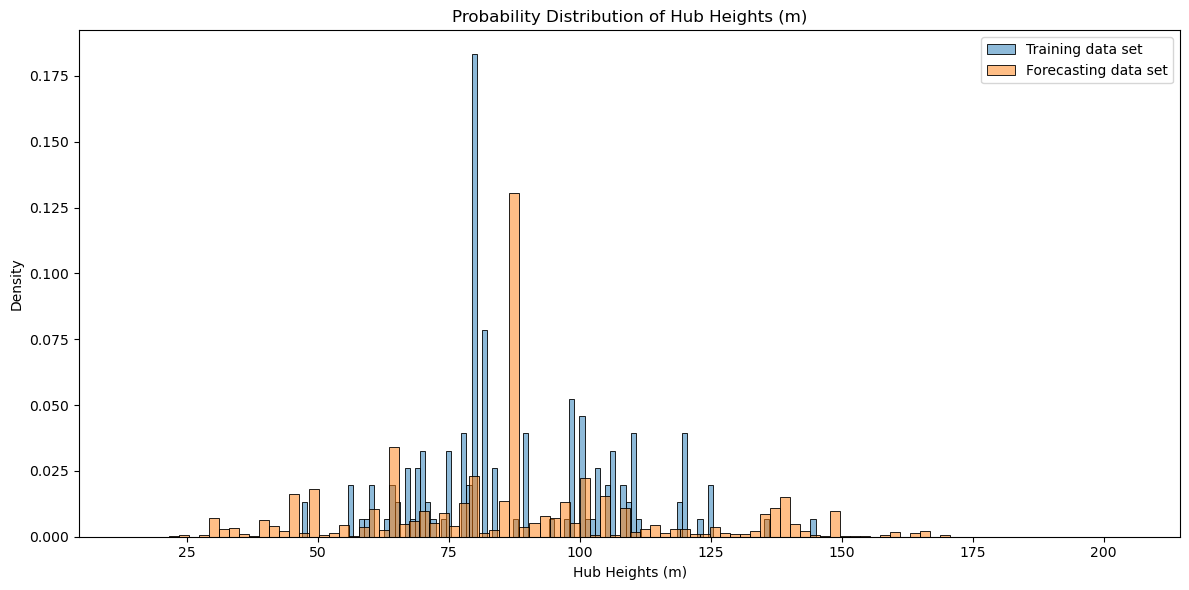

Training data set: minimal Capacities (MW): 7.9740932642487055, maximal Capacities (MW): 407.0
Forecasting data set: minimal Capacities (MW): 0.1, maximal Capacities (MW): 1386.0


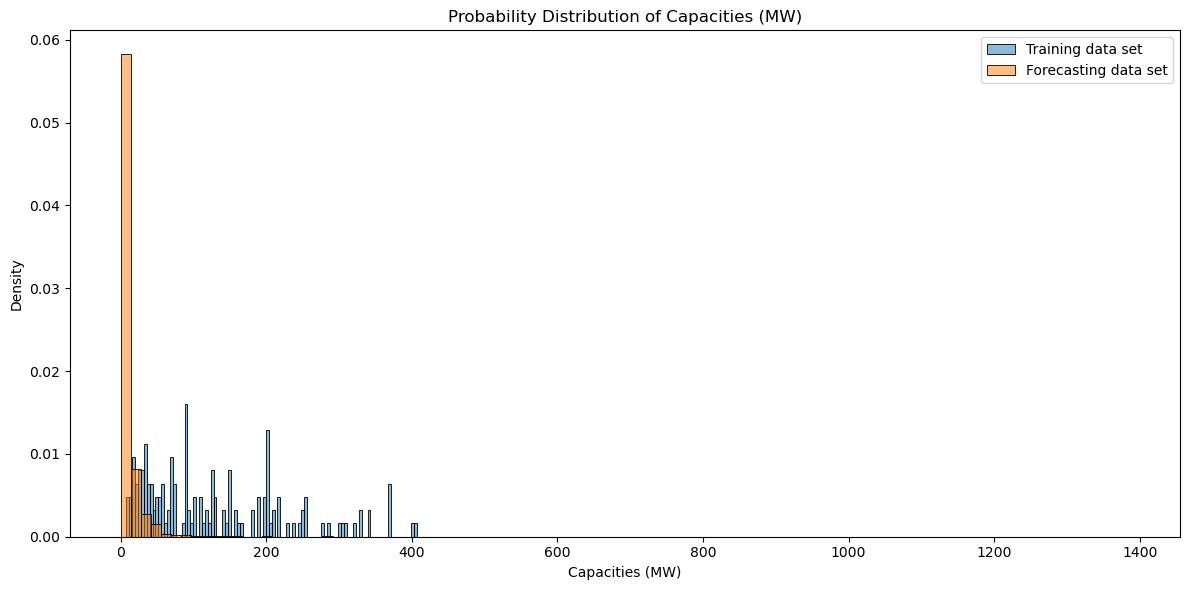

Training data set: minimal Ages (months): 7, maximal Ages (months): 288
Forecasting data set: minimal Ages (months): 4, maximal Ages (months): 558


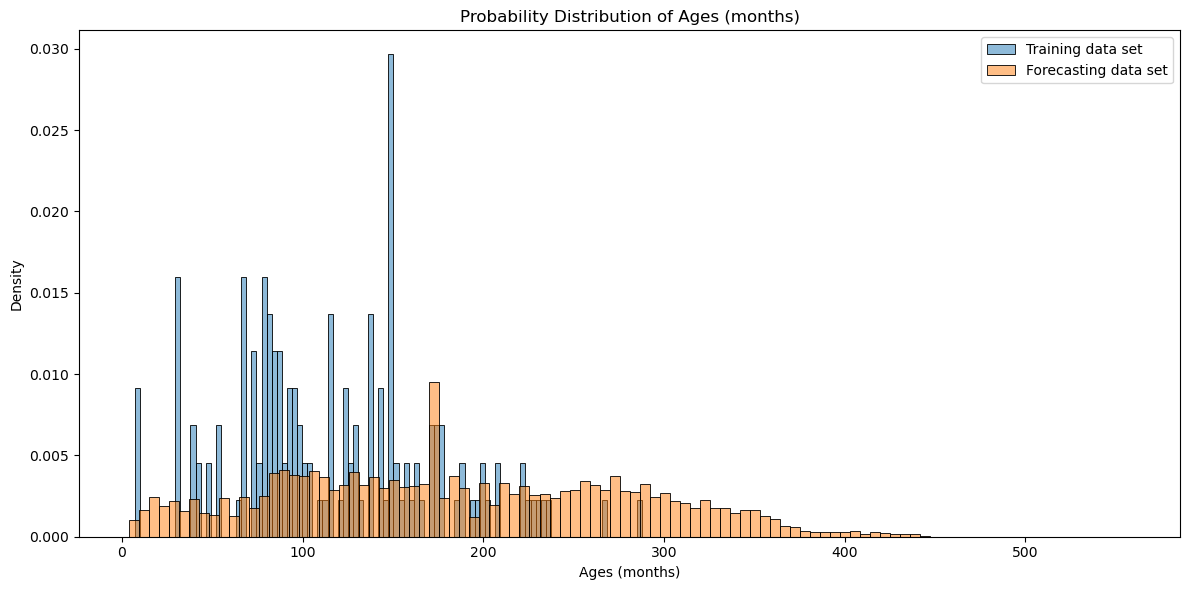

Training data set: minimal Wind Speeds (m/s): 0.06, maximal Wind Speeds (m/s): 34.2


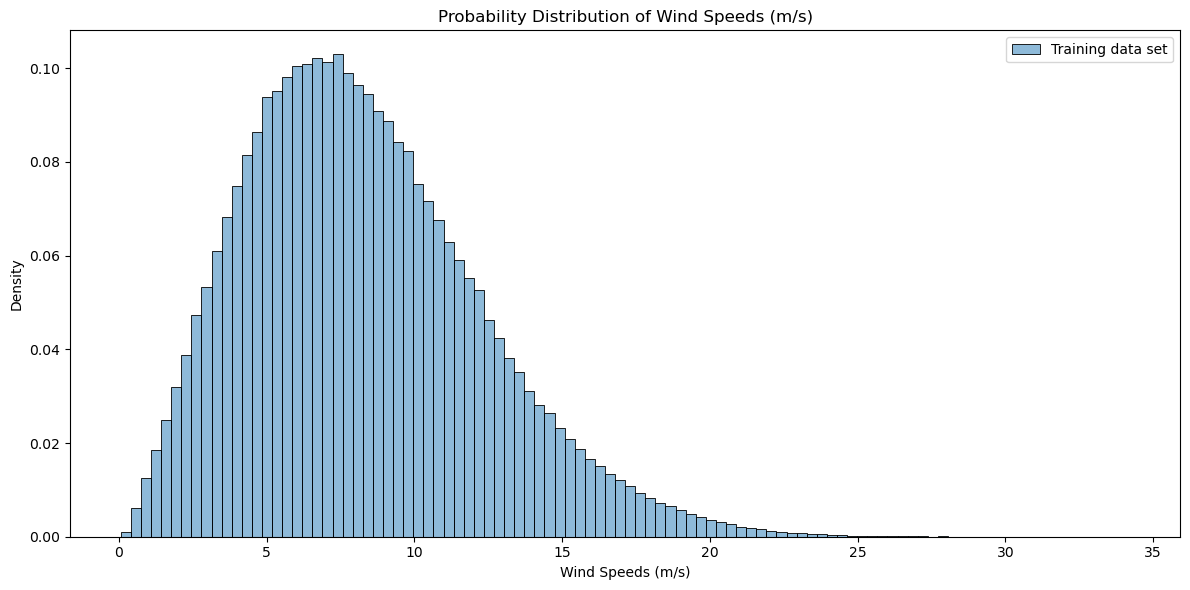

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import OneHotEncoder

# Load WPP + Production Wind JSON data
with open("data/WPPs+production+reanalysis/WPPs+production+wind_new.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# Load The Wind Power data (Parquet)
df = pd.read_parquet("data_hosting/The_Wind_Power.parquet")

# Load turbine type encoder categories
encoder = OneHotEncoder(sparse_output=False)
all_turbine_types = [str(wpp["Turbine"]) for wpp in WPP_production_wind]
encoder.fit(np.array(all_turbine_types).reshape(-1, 1))
turbine_categories = encoder.categories_[0]

# Create a new "Other/Unknown" category for unmatched turbine types in the second dataset
df["Turbine Category"] = df["Turbine"].apply(lambda x: x if x in turbine_categories else "nan")

# Prepare features for Training dataset
features_wind = {
    "Turbine Types": [str(wpp["Turbine"]) for wpp in WPP_production_wind],
    "Hub Heights (m)": [wpp["Hub_height"] for wpp in WPP_production_wind],
    "Capacities (MW)": [wpp["Capacity"] for wpp in WPP_production_wind],
    "Ages (months)": (pd.Timestamp("2024-12-01") - pd.to_datetime(
        [f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"]
         else wpp["Commissioning_date"] for wpp in WPP_production_wind], format='%Y/%m')).days // 30,
    "Wind Speeds (m/s)": [entry[2] for wpp in WPP_production_wind for entry in wpp["Production"]]
}

# Prepare features for Forecasting dataset
features_twp = {
    "Turbine Types": df["Turbine Category"].values,
    "Hub Heights (m)": df["Hub height"].values,
    "Capacities (MW)": df["Total power"].values / 1e3,  # Convert from kW to MW
    "Ages (months)": df["Ages months"].values,
}

# Plotting function
def plot_feature_distribution(feature_name, data_wind, data_twp=None, is_discrete=False):
    plt.figure(figsize=(12, 6))
    if is_discrete:
        # Normalise frequencies within each dataset
        wind_df = pd.DataFrame({"Source": "Training data set", feature_name: data_wind})
        wind_df = wind_df[feature_name].value_counts(normalize=True).reset_index().rename(columns={"index": feature_name})
        wind_df["Source"] = "Training data set"

        twp_df = pd.DataFrame({"Source": "Forecasting data set", feature_name: data_twp}) if data_twp is not None else None
        if twp_df is not None:
            twp_df = twp_df[feature_name].value_counts(normalize=True).reset_index().rename(columns={"index": feature_name})
            twp_df["Source"] = "Forecasting data set"
            combined_data = pd.concat([wind_df, twp_df]).reset_index(drop=True)
        else:
            combined_data = wind_df

        # Bar plot with "dodge" to display bars side by side
        sns.barplot(data=combined_data, x=feature_name, y="proportion", hue="Source", dodge=True)
        plt.xticks(rotation=90)
        plt.legend(title="Dataset")

        print(f"Training data set: number of turbine types {len(set(data_wind))}")
        print(f"Forecasting data set: number of turbine types {len(set(df["Turbine"]))}")
    else:
        # Histogram with very thin bars (binwidth=0.1)
        sns.histplot(data_wind, label="Training data set", bins=100, alpha=0.5, kde=False, stat="density")
        print(f"Training data set: minimal {feature_name}: {min(data_wind)}, maximal {feature_name}: {max(data_wind)}")
        if data_twp is not None:
            sns.histplot(data_twp, label="Forecasting data set", bins=100, alpha=0.5, kde=False, stat="density")
            print(f"Forecasting data set: minimal {feature_name}: {min(data_twp)}, maximal {feature_name}: {max(data_twp)}")
    
    plt.title(f"Probability Distribution of {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Relative Frequency" if is_discrete else "Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot probability distributions
plot_feature_distribution("Turbine Types", features_wind["Turbine Types"], features_twp["Turbine Types"], is_discrete=True)
plot_feature_distribution("Hub Heights (m)", features_wind["Hub Heights (m)"], features_twp["Hub Heights (m)"])
plot_feature_distribution("Capacities (MW)", features_wind["Capacities (MW)"], features_twp["Capacities (MW)"])
plot_feature_distribution("Ages (months)", features_wind["Ages (months)"], features_twp["Ages (months)"])
plot_feature_distribution("Wind Speeds (m/s)", features_wind["Wind Speeds (m/s)"])

<h1>Boxplots Capacities

Mean capacity (Training WPPs): 125.90 MW
Mean capacity (Forecasting WPPs): 10.91 MW


C:\Users\alexa\AppData\Local\Temp\ipykernel_26660\1570171284.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=False, patch_artist=True, labels=["Forecasting WPPs", "Training WPPs"], positions=[1, 1.5], widths=0.3)


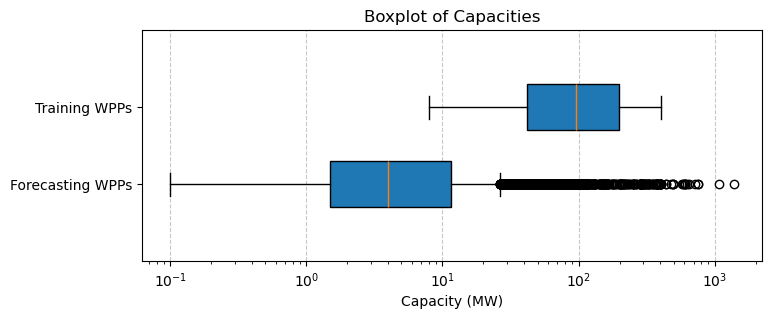

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

# Read data
df = pd.read_parquet("data/WPPs/The_Wind_Power.parquet")
capacities_the_wind_power = df['Total power'].values / 1e3  # Convert to MW

# Load WPP + Production Wind JSON data
with open("data/WPPs+production+wind/WPPs+production+wind_new.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

capacities_ENTSO_E = [wpp["Capacity"] for wpp in WPP_production_wind]

# Calculate means
mean_all_capacities = np.mean(capacities_ENTSO_E)
mean_capacities_the_wind_power = np.mean(capacities_the_wind_power)

# Print the mean values and scaling factor
print(f"Mean capacity (Training WPPs): {mean_all_capacities:.2f} MW")
print(f"Mean capacity (Forecasting WPPs): {mean_capacities_the_wind_power:.2f} MW")

# Plot boxplot
data = [capacities_the_wind_power, capacities_ENTSO_E]

plt.figure(figsize=(8, 3))
plt.boxplot(data, vert=False, patch_artist=True, labels=["Forecasting WPPs", "Training WPPs"], positions=[1, 1.5], widths=0.3)
plt.title("Boxplot of Capacities")
plt.xlabel("Capacity (MW)")
plt.xscale("log")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

<h1> Statuses forecasting WPPs

In [25]:
import pandas as pd

# Load the Excel file
WPP_file = "data/WPPs/Windfarms_Europe_20241123.xlsx"
df = pd.read_excel(WPP_file, sheet_name='Windfarms', na_values=["#ND"])
df = df.drop(0)  # remove the first row (after headlines)

# Select relevant columns
df = df[['Status']]

# Calculate and display the shares of different status classes
status_counts = df['Status'].value_counts(normalize=True) * 100
status_shares = status_counts.round(2).to_dict()

status_shares

{'Production': 88.11,
 'Dismantled': 8.73,
 'Planned': 2.01,
 'Construction': 1.04,
 'Approved': 0.11}

<h1>Visualisation of real productions

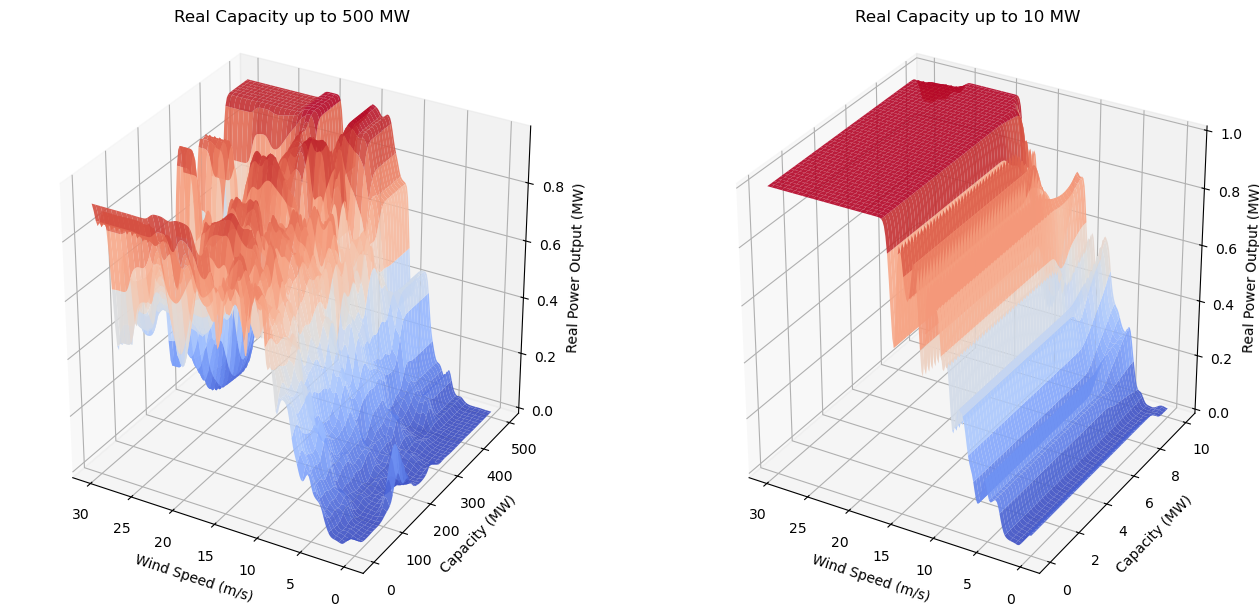

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# Extract wind speeds, capacities, and real outputs
wind_speeds_real = combined_features_raw[:, -1]  # Last column is wind speed
real_outputs = output_raw.flatten()
capacities_real = capacities_real.flatten()

# Reduce dataset size for interpolation (max 5k points)
sample_size = min(len(real_outputs), 10_000)
random_indices = np.random.choice(len(real_outputs), sample_size, replace=False)

wind_speeds_real = wind_speeds_real[random_indices]
real_outputs = real_outputs[random_indices]
capacities_real_used = capacities_real[random_indices]

# Define a function to generate the real output plot
def generate_real_plot(capacities, ax):
    wind_speeds_grid, capacities_grid = np.meshgrid(
        np.linspace(0, 30, 200),  # Increase resolution for smoother interpolation
        capacities
    )
    wind_speeds_flat = wind_speeds_grid.flatten()
    capacities_flat = capacities_grid.flatten()

    # Interpolate real output data (use cubic if sufficient data points exist)
    real_outputs_interpolated = griddata(
        (wind_speeds_real, capacities_real_used), real_outputs,
        (wind_speeds_flat, capacities_flat), method='linear'
    )

    # Handle NaNs by filling them with nearest-neighbor interpolation
    nan_mask = np.isnan(real_outputs_interpolated)
    if np.any(nan_mask):
        real_outputs_interpolated[nan_mask] = griddata(
            np.column_stack((wind_speeds_real, capacities_real_used)),
            real_outputs,
            np.column_stack((wind_speeds_flat[nan_mask], capacities_flat[nan_mask])),
            method='nearest'
        )

    # Apply Gaussian filter to smooth the output
    real_outputs_grid = gaussian_filter(real_outputs_interpolated.reshape(wind_speeds_grid.shape), sigma=2)

    # Plot the real output surface
    surf = ax.plot_surface(
        wind_speeds_grid, capacities_grid, real_outputs_grid,
        cmap='coolwarm', edgecolor='none', alpha=0.9
    )

    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel("Wind Speed (m/s)")
    ax.set_ylabel("Capacity (MW)")
    ax.set_zlabel("Real Power Output (MW)")
    ax.set_title("Real Power Output Surface")
    ax.set_box_aspect([1, 1, 1])

# Create the plots for real output
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121, projection='3d')
generate_real_plot(np.linspace(0, 500, 100), ax1)
ax1.set_title("Real Capacity up to 500 MW")

ax2 = fig.add_subplot(122, projection='3d')
generate_real_plot(np.linspace(0, 10, 100), ax2)
ax2.set_title("Real Capacity up to 10 MW")

plt.show()


<h1>From Preprocessing

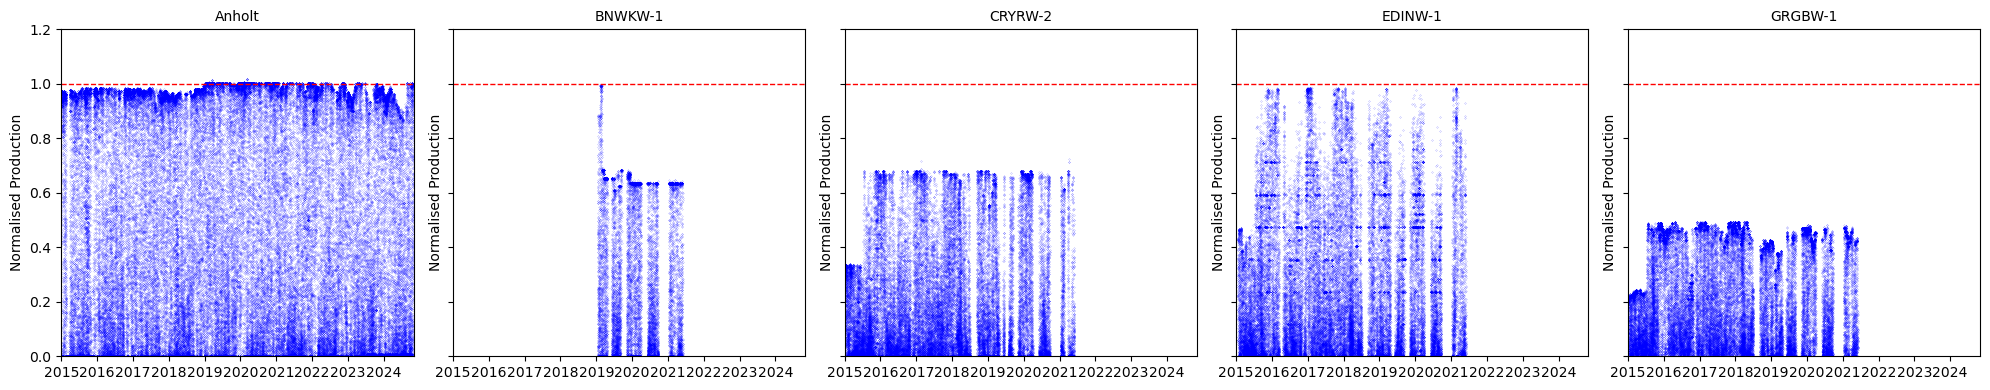

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load JSON data
with open("data/production_history/production_summary_all.json", "r", encoding="utf-8") as file:
    production_data = json.load(file)

# Filter production data for specific wind farms
selected_units = ["Anholt", "BNWKW-1", "EDINW-1", "CRYRW-2", "GRGBW-1"]
filtered_data = [unit for unit in production_data if unit["GenerationUnitName"] in selected_units]

# Sort production data by GenerationUnitName
filtered_data = sorted(filtered_data, key=lambda x: x["GenerationUnitName"])

# Define subplot grid size
num_units = len(filtered_data)
cols = num_units
rows = 1  # Single row

# Create figure and subplot
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4), sharex=True, sharey=True)

# Ensure axes is iterable
if num_units == 1:
    axes = [axes]

# Iterate over generation units and plot
for i, unit in enumerate(filtered_data):
    ax = axes[i]

    # Extract production data
    production_records = unit["Production"]
    capacity = unit["GenerationUnitInstalledCapacity(MW)"]

    # Convert to DataFrame
    df = pd.DataFrame(production_records, columns=["date", "production"])
    df["date"] = pd.to_datetime(df["date"])
    df["production"] = df["production"].astype(float)

    # Normalize production by capacity
    df["normalised_production"] = df["production"] / capacity if capacity else None

    # Scatter plot of normalized production over time
    ax.scatter(df["date"], df["normalised_production"], s=0.01, c="blue")
    ax.set_title(unit["GenerationUnitName"], fontsize=10)
    ax.set_ylabel("Normalised Production")
    ax.axhline(y=1, color="red", linestyle="--", linewidth=1)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(pd.Timestamp("2015-01-01"), pd.Timestamp("2024-10-31"))

plt.tight_layout()
plt.show()

<h1>From Preprocessing_modelB

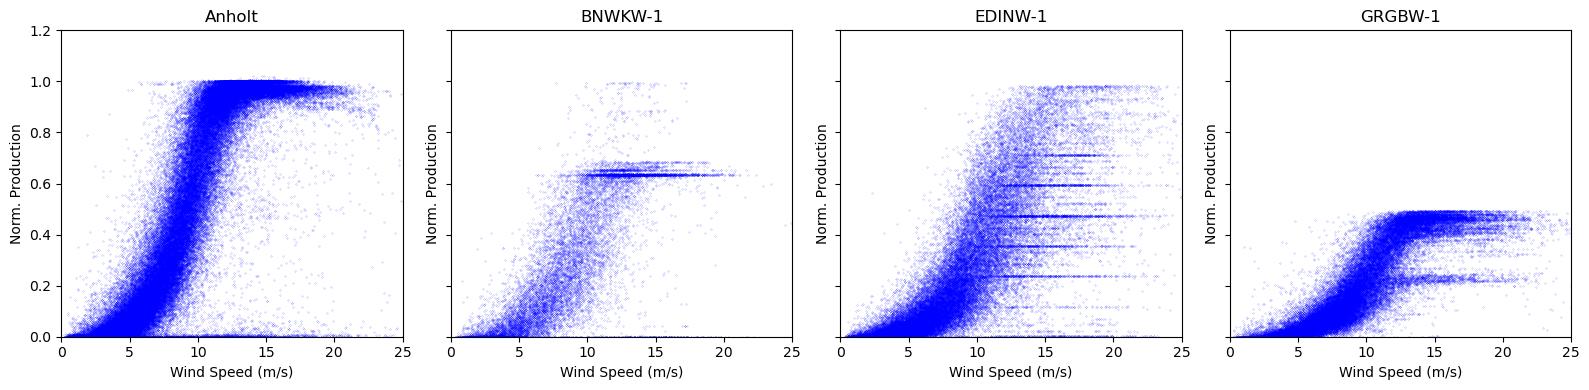

In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load JSON data
with open("data/WPPs+production+reanalysis/WPPs+production+wind_new.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# Filter WPPs for selected names (only unique occurrences)
selected_wpps = ["Anholt", "BNWKW-1", "EDINW-1", "GRGBW-1"]
filtered_wpps = []
seen_names = set()
for name in selected_wpps:
    for wpp in WPP_production_wind:
        if wpp["Name"] == name and name not in seen_names:
            filtered_wpps.append(wpp)
            seen_names.add(name)
            break

# Define subplot grid size
num_wpps = len(filtered_wpps)
cols = num_wpps
rows = 1  # Single row

# Create figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4), sharex=True, sharey=True)

# Ensure axes is iterable
if num_wpps == 1:
    axes = [axes]

# Iterate over WPPs and plot
for i, wpp in enumerate(filtered_wpps):
    ax = axes[i]

    # Extract production and wind speed data
    production_data = wpp["Production"]
    capacity = wpp["Capacity"]

    # Convert to DataFrame
    df = pd.DataFrame(production_data, columns=["date", "production", "wind_speed"])
    df["production"] = df["production"].astype(float)
    df["wind_speed"] = df["wind_speed"].astype(float)

    # Normalize production
    df["normalized_production"] = df["production"] / capacity if capacity else None

    # Scatter plot
    ax.scatter(df["wind_speed"], df["normalized_production"], s=0.01, c="blue")
    ax.set_title(wpp["Name"])
    ax.set_xlabel("Wind Speed (m/s)")
    ax.set_xlim(0, 25)
    ax.set_ylabel("Norm. Production")
    ax.set_ylim(0, 1.2)

plt.tight_layout()
plt.show()

<h1>Heatmap available data

C:\Users\alexa\AppData\Local\Temp\ipykernel_28404\3353604771.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("coolwarm", 2)  # 2 colors for presence/absence


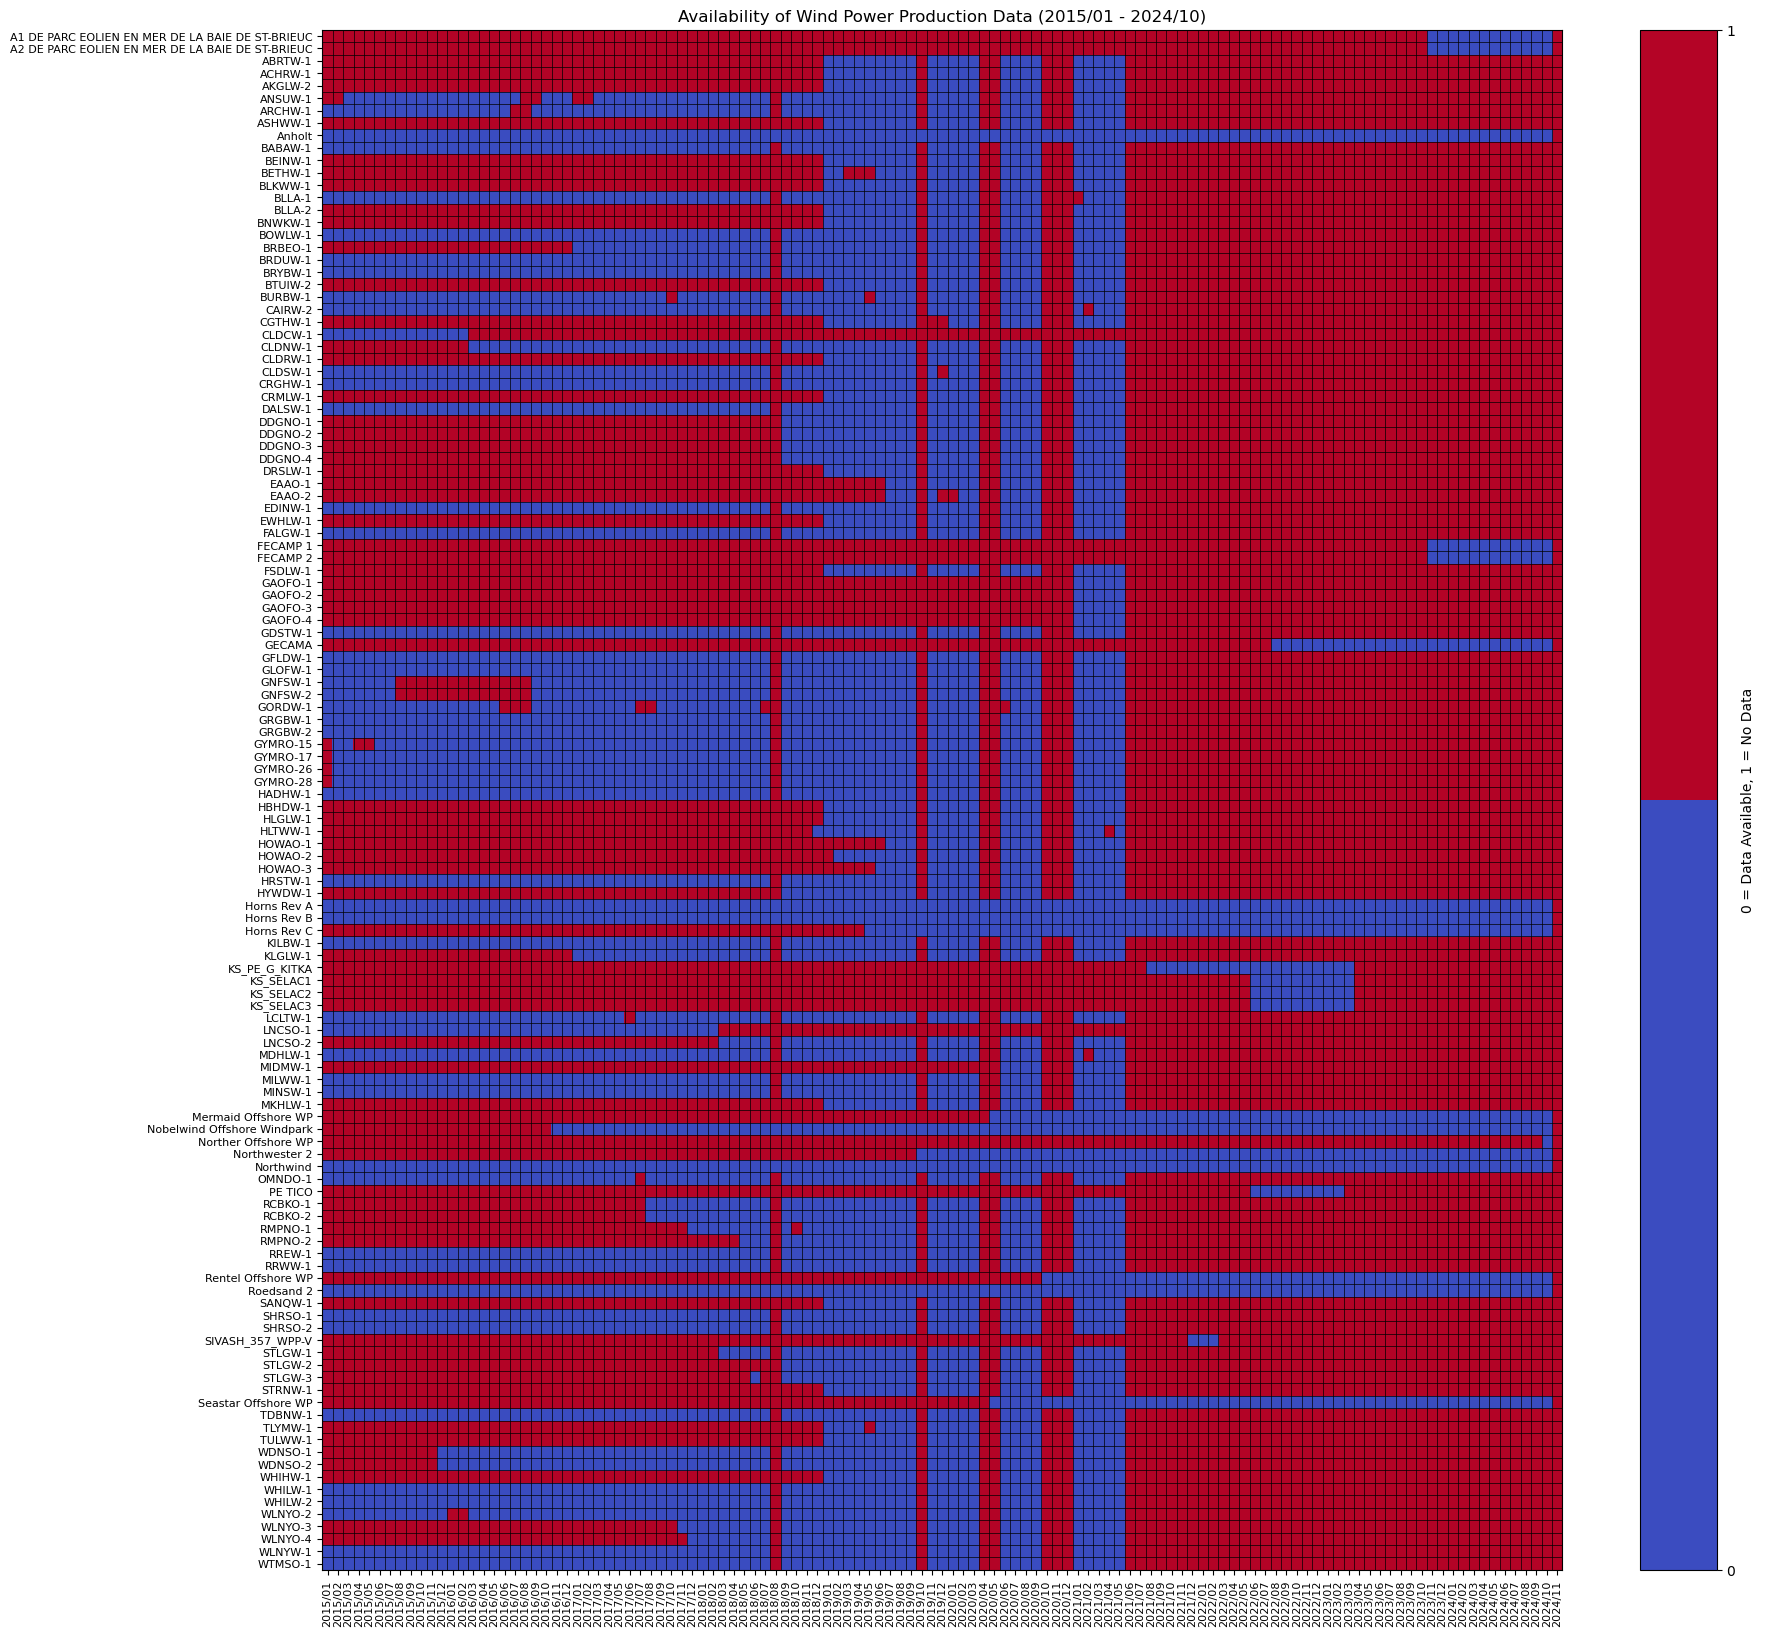

In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load JSON data
file_path = "data/WPPs+production/WPPs+production_new_complete.json"
with open(file_path, "r", encoding="utf-8") as file:
    wpps_data = json.load(file)

# Define the date range (months from 2015/01 to 2024/10)
date_range = pd.date_range(start="2015-01", end="2024-11", freq="MS").strftime("%Y/%m").tolist()

# Initialize the results dictionary
wpp_table = {}

# Process each WPP entry
for wpp in wpps_data:
    wpp_name = wpp["Name"]
    wpp_table[wpp_name] = {month: 1 for month in date_range}  # Default to 1 (no data)

    # Extract available months from production data
    available_months = set(pd.to_datetime([entry[0] for entry in wpp["Production"]]).strftime("%Y/%m"))

    # Mark months with data as 0
    for month in available_months:
        if month in wpp_table[wpp_name]:  # Only update if in defined range
            wpp_table[wpp_name][month] = 0

# Convert to DataFrame
df_wpp_table = pd.DataFrame.from_dict(wpp_table, orient="index")

# Convert values to a numpy array for color mapping
data_matrix = df_wpp_table.values

# Create figure and axis for heatmap display
fig, ax = plt.subplots(figsize=(min(df_wpp_table.shape[1] * 0.2, 20), min(df_wpp_table.shape[0] * 0.2, 20)))

# Create heatmap
cmap = plt.cm.get_cmap("coolwarm", 2)  # 2 colors for presence/absence
heatmap = ax.imshow(data_matrix, aspect="auto", cmap=cmap)

# Set labels
ax.set_xticks(np.arange(df_wpp_table.shape[1]))
ax.set_yticks(np.arange(df_wpp_table.shape[0]))
ax.set_xticklabels(df_wpp_table.columns, rotation=90, fontsize=8)
ax.set_yticklabels(df_wpp_table.index, fontsize=8)

# Add grid lines for clarity
ax.set_xticks(np.arange(data_matrix.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(data_matrix.shape[0] + 1) - 0.5, minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)

# Hide minor tick labels
ax.tick_params(which="minor", bottom=False, left=False)

# Show plot
plt.title("Availability of Wind Power Production Data (2015/01 - 2024/10)")
plt.colorbar(heatmap, ticks=[0, 1], label="0 = Data Available, 1 = No Data")
plt.show()


<h1>Spearman Correlation Matrix 2019 data

prepare data (JSON file)

In [ ]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import interp2d

# Load JSON data (WPP production and metadata)
json_path = "data/WPPs+production/WPPs+production_new_complete.json"
with open(json_path, "r", encoding="utf-8") as file:
    wpps_data = json.load(file)

ref_date = pd.Timestamp("2024-12-01")

# Initialize list to store extracted data
wpp_records = []

# Load weather data from ERA5 GRIB file
wind_data = xr.open_dataset(r"E:\MA_data\reanalysis\2019.grib", engine="cfgrib")
temp_data = xr.open_dataset(r"E:\MA_data\reanalysis\2019_temp.grib", engine="cfgrib")
pressure_data = xr.open_dataset(r"E:\MA_data\reanalysis\2019_pressure.grib", engine="cfgrib")

times = pd.to_datetime(wind_data['time'].values)
latitudes = wind_data['latitude'].values
longitudes = wind_data['longitude'].values
u_values = wind_data["u100"].values
v_values = wind_data["v100"].values
temp_values = temp_data["t2m"].values
pressure_values = pressure_data["sp"].values

# Process each WPP entry
for i, wpp in enumerate(wpps_data):
    print(f"Processing WPP {i} / {len(wpps_data)}")
    wpp_name = wpp["Name"]
    location = (wpp["Latitude"], wpp["Longitude"])
    hub_height = wpp["Hub_height"]
    commissioning_date = f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"]
    standardised_dates = pd.to_datetime(commissioning_date, format='%Y/%m')
    age = (ref_date.year - standardised_dates.year) * 12 + (ref_date.month - standardised_dates.month)

    # Extract production data for 2019
    for record in wpp["Production"]:
        date, production = record
        date_parsed = pd.to_datetime(date)
        
        if date_parsed.year == 2019 and date_parsed in times:
            time_index = times.get_loc(date_parsed)

            normalised_production = production / wpp["Capacity"]
            
            # Interpolators for weather data
            temp_interpolator = interp2d(longitudes, latitudes, temp_values[time_index], kind='linear')
            pressure_interpolator = interp2d(longitudes, latitudes, pressure_values[time_index], kind='linear')
            u_interpolator = interp2d(longitudes, latitudes, u_values[time_index], kind='linear')
            v_interpolator = interp2d(longitudes, latitudes, v_values[time_index], kind='linear')

            # Interpolate weather data
            temp = temp_interpolator(location[1], location[0])[0]
            pressure = pressure_interpolator(location[1], location[0])[0]
            u = u_interpolator(location[1], location[0])[0]
            v = v_interpolator(location[1], location[0])[0]
            wind_speed = np.sqrt(u**2 + v**2)
            wind_direction = (np.arctan2(v, u) * (180 / np.pi)) % 360
            
            wpp_records.append({
                "Name": wpp_name,
                "Date": date_parsed,
                "Latitude": location[0],
                "Longitude": location[1],
                "Hub Height": hub_height,
                "Age": age,
                "Time Series": [
                    normalised_production,
                    temp,
                    pressure,
                    wind_speed,
                    wind_direction
                ]
            })

# Convert extracted data to DataFrame
df_production = pd.DataFrame(wpp_records)

# Save the extracted data as a JSON file
output_json_path = "data/WPPs+production/WPPs+production_2019.json"
df_production.to_json(output_json_path, orient="records", date_format="iso", indent=4)
print(f"Saved extracted data to {output_json_path}")

create matrix

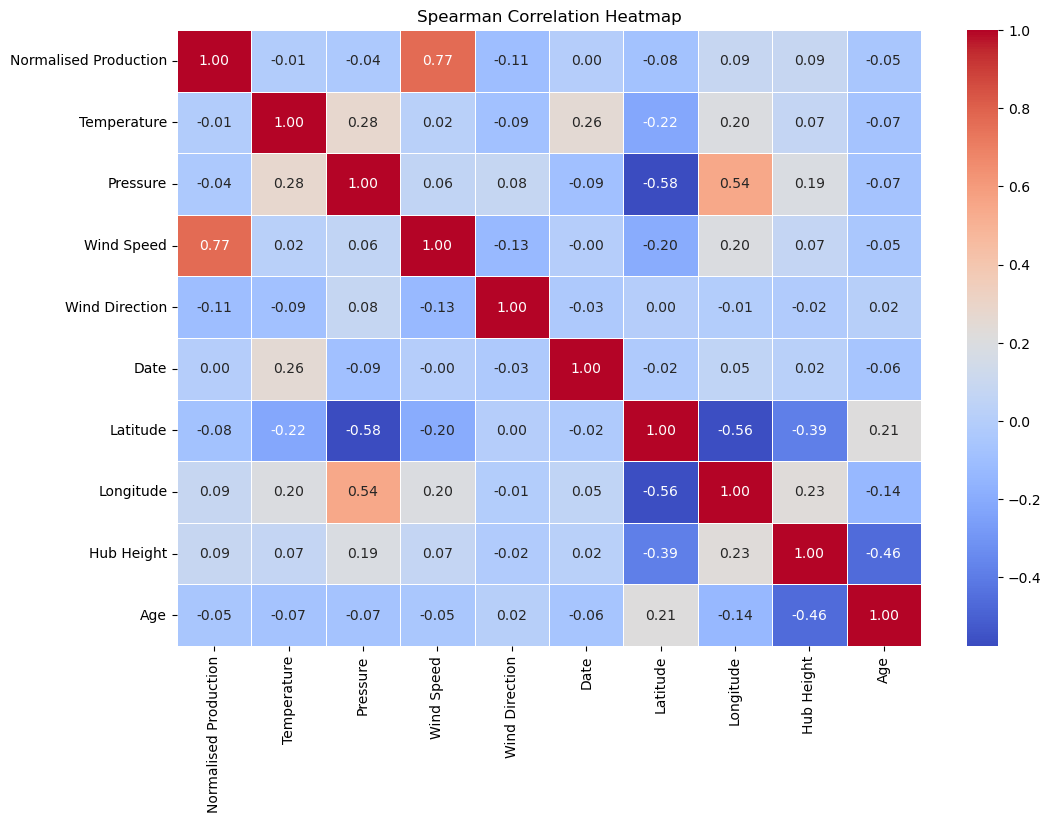

In [68]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load JSON data
json_path = "data/WPPs+production/WPPs+production_2019.json"
with open(json_path, "r", encoding="utf-8") as file:
    wpps_data = json.load(file)

# Convert JSON to DataFrame
df_production = pd.DataFrame(wpps_data)

# Expand the "Time Series" column into separate attributes
df_production[["Normalised Production", "Temperature", "Pressure", "Wind Speed", "Wind Direction"]] = pd.DataFrame(df_production["Time Series"].tolist(), index=df_production.index)

# Convert "Date" to a numeric value (timestamp)
df_production["Date"] = pd.to_datetime(df_production["Date"]).astype("int64") / 10**9  # Convert to seconds since epoch

# Drop non-numeric columns
df_numeric = df_production.drop(columns=["Name", "Time Series"], errors="ignore")

# Define the desired column order
column_order = ["Normalised Production", "Temperature", "Pressure", "Wind Speed", "Wind Direction", 
                "Date", "Latitude", "Longitude", "Hub Height", "Age"]

# Reorder the DataFrame columns
df_numeric = df_numeric[column_order]

# Compute Spearman Correlation Matrix
spearman_corr_matrix = df_numeric.corr(method="spearman")

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Spearman Correlation Heatmap")
plt.show()
